In [1]:
import torch
from torch import nn
import d2l_self  as d2l

In [2]:
net=nn.Sequential(nn.Conv2d(1,6,kernel_size=5,padding=2),nn.Sigmoid(),
                  nn.AvgPool2d(kernel_size=2,stride=2),
                  nn.Conv2d(6,16,kernel_size=5),nn.Sigmoid(),
                  nn.AvgPool2d(kernel_size=2,stride=2),
                  nn.Flatten(),
                  nn.Linear(16*5*5,120),nn.Sigmoid(),
                  nn.Linear(120,84),nn.Sigmoid(),
                  nn.Linear(84,10))    

In [3]:
X=torch.rand(size=(1,1,28,28),dtype=torch.float32)
for layer in net:
    X=layer(X)
    print(layer.__class__.__name__,'output shape:\t',X.shape)

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
Sigmoid output shape:	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
Sigmoid output shape:	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


In [4]:
batch_size=256
train_iter,test_iter=d2l.load_data_fashion_mnist(batch_size=batch_size)

In [5]:
def evaluate_accuracy_gpu(net,data_iter,device=None):
    if isinstance(net,nn.Module):
        net.eval()
    if not device:
        device=next(iter(net.parameters())).device#iter(net.parameters())，变成迭代器，建议取出张量
    metric=d2l.Accumulator(2)
    with torch.no_grad():
        for X,y in data_iter:
            if isinstance(X,list):
                X=[x.to(device) for x in X]
            else:
                X=X.to(device)
            y=y.to(device)
            metric.add(d2l.accuracy(net(X),y),y.numel())
    return metric[0]/metric[1]

In [6]:
def train_ch6(net,train_iter,test_iter,num_epochs,lr,device):
    def init_weights(m):
        if type(m)==nn.Linear or type(m)==nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on',device)
    net.to(device)
    optimizer=torch.optim.SGD(net.parameters(),lr=lr)
    loss=nn.CrossEntropyLoss()
    animator=d2l.Animator(xlabel='epoch',xlim=[1,num_epochs],
                          legend=['train loss','train accuracy','test accuracy'])
    timer,num_batches=d2l.Timer(),len(train_iter)
    for epoch in range(num_epochs):
        metric=d2l.Accumulator(3)
        net.train()
        for i,(X,y)in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X,y=X.to(device),y.to(device)
            y_hat=net(X)
            l=loss(y_hat,y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l*X.shape[0],d2l.accuracy(y_hat,y),X.shape[0])
            timer.stop()
            train_l=metric[0]/metric[2]
            train_acc=metric[1]/metric[2]
            if (i+1)%(num_batches//5)==0 or i==num_batches-1:
                animator.add(epoch+(i+1)/num_batches,(train_l,train_acc,None))
        test_acc=evaluate_accuracy_gpu(net,test_iter)
        animator.add(epoch+1,(None,None,test_acc))
    print(f'loss{train_l:.3f},train_acc {train_acc:.3f}' f'test acc{test_acc:.3f}')
    print(f'{metric[2]*num_epochs/timer.sum():.1f}examples/sec'
          f'on {str(device)}')



loss0.466,train_acc 0.825test acc0.814
1169.6examples/secon cpu


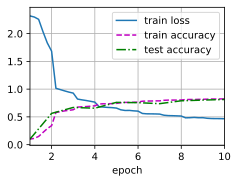

In [7]:
lr,num_epochs=0.9,10
train_ch6(net,train_iter,test_iter,num_epochs,lr,d2l.try_gpu())

In [8]:
#Alex
net2=nn.Sequential(nn.Conv2d(1,96,kernel_size=11,stride=4,padding=1),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3,stride=2),
                   nn.Conv2d(96,256,kernel_size=5,padding=2),nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3,stride=2),
                   nn.Conv2d(256,384,kernel_size=3,padding=1),nn.ReLU(),
                   nn.Conv2d(384,384,kernel_size=3,padding=1),nn.ReLU(),
                    nn.Conv2d(384,256,kernel_size=3,padding=1),nn.ReLU(),
                    nn.MaxPool2d(kernel_size=3,stride=2),
                    nn.Flatten(),
                    nn.Linear(6400,4096),nn.ReLU(),nn.Dropout(p=0.5),
                    nn.Linear(4096,4096),nn.ReLU(),nn.Dropout(p=0.5),
                    nn.Linear(4096,10)
                    )

In [9]:
X=torch.rand(1,1,224,224)
for layer in net2:
    X=layer(X)
    print(layer.__class__.__name__,'output shape:\t',X.shape)

Conv2d output shape:	 torch.Size([1, 96, 54, 54])
ReLU output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Conv2d output shape:	 torch.Size([1, 256, 26, 26])
ReLU output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 256, 12, 12])
ReLU output shape:	 torch.Size([1, 256, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 256, 5, 5])
Flatten output shape:	 torch.Size([1, 6400])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1,

In [10]:
#读取数据集
batch_size_1=128
train_iter_1,test_iter_1=d2l.load_data_fashion_mnist(batch_size_1,resize=224)#进行缩放/放大成224*224才能放入Alexnet

training on cpu


RuntimeError: mat1 and mat2 shapes cannot be multiplied (128x46656 and 400x120)

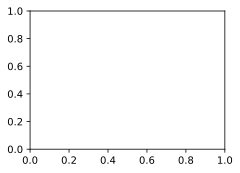

In [11]:
lr_1,num_epochs_1=0.01,10
d2l.train_ch6(net,train_iter_1,test_iter_1,num_epochs_1,lr_1,d2l.try_gpu())